## Library Imports

In [1]:
from time import time
notebook_start_time = time()

In [2]:
import os
import re
import gc
import pickle
import random as r
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
from torchvision import models, transforms

from time import time
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

## Constants and Utilities

In [3]:
SEED = 49
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_FEATURES = 1664
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225]),
                                ])

PATH = "../input/petfinder-pawpularity-score"
IMAGE_PATH = "../input/petfinder-pretrained-images-nocrop"

verbose = True
DEBUG = False

sc_y = StandardScaler()

In [4]:
def breaker(num=50, char="*") -> None:
    print("\n" + num*char + "\n")


def get_targets(path: str) -> np.ndarray:
    df = pd.read_csv(os.path.join(path, "train.csv"), engine="python")
    targets = df["Pawpularity"].copy().values
    return targets.reshape(-1, 1)


def show_graphs(L: list, title=None) -> None:
    TL, VL = [], []
    for i in range(len(L)):
        TL.append(L[i]["train"])
        VL.append(L[i]["valid"])
    x_Axis = np.arange(1, len(L) + 1)
    plt.figure()
    plt.plot(x_Axis, TL, "r", label="train")
    plt.plot(x_Axis, VL, "b", label="valid")
    plt.grid()
    plt.legend()
    if title:
        plt.title("{} Loss".format(title))
    else:
        plt.title("Loss")
    plt.show()

## Dataset Template and Build Dataloader

In [5]:
class DS(Dataset):
    def __init__(self, images=None, targets=None, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        return self.transform(self.images[idx]), torch.FloatTensor(self.targets[idx])


def build_dataloaders(tr_images: np.ndarray, va_images: np.ndarray,
                      tr_targets: np.ndarray, va_targets: np.ndarray,
                      batch_size: int, seed: int, transform: transforms.transforms.Compose):

    if verbose:
        breaker()
        print("Building Train and Validation DataLoaders ...")
    
    tr_data_setup = DS(images=tr_images, targets=tr_targets, transform=transform)
    va_data_setup = DS(images=va_images, targets=va_targets, transform=transform)
    
    dataloaders = {
        "train" : DL(tr_data_setup, batch_size=batch_size, shuffle=True, generator=torch.manual_seed(seed)),
        "valid" : DL(va_data_setup, batch_size=batch_size, shuffle=False)
    }
    
    return dataloaders

## Build Model

In [6]:
def build_model(IL: int, seed: int):
    class Model(nn.Module):
        def __init__(self, IL=None):
            super(Model, self).__init__()

            self.features = models.densenet169(pretrained=True, progress=False)
            self.features = nn.Sequential(*[*self.features.children()][:-1])
            self.freeze()
            self.features.add_module("Adaptive Average Pool", nn.AdaptiveAvgPool2d(output_size=(1, 1)))
            self.features.add_module("Flatten", nn.Flatten())

            self.predictor = nn.Sequential()
            self.predictor.add_module("BN", nn.BatchNorm1d(num_features=IL, eps=1e-5))
            self.predictor.add_module("FC", WN(nn.Linear(in_features=IL, out_features=1)))
        
        def freeze(self):
            for params in self.parameters():
                params.requires_grad = False
            
            for names, params in self.named_parameters():
                if re.match(r"features.0.denseblock4", names, re.IGNORECASE):
                    params.requires_grad = True
                if re.match(r"features.0.norm5", names, re.IGNORECASE):
                    params.requires_grad = True
        
        def get_optimizer(self, lr=1e-3, wd=0.0):
            params = [p for p in self.parameters() if p.requires_grad]
            return optim.SGD(params, lr=lr, momentum=0.9, weight_decay=wd)
        
        def forward(self, x1, x2=None):
            if x2 is not None:
                x1 = self.features(x1)
                x2 = self.features(x2)
                return self.predictor(x1), self.predictor(x2)
            else:
                x1 = self.features(x1)
                return self.predictor(x1)
        
    if verbose:
        breaker()
        print("Building Model ...")

    torch.manual_seed(seed)
    model = Model(IL=IL)
    return model

## Fit and Predict

In [7]:
def fit(model=None, optimizer=None, scheduler=None, 
        epochs=None, early_stopping_patience=None,
        dataloaders=None, fold=None, verbose=False) -> tuple:
    
    name = "./Fold_{}_state.pt".format(fold)
    
    if verbose:
        breaker()
        print("Training Fold {}...".format(fold))
        breaker()
    else:
        print("Training Fold {}...".format(fold))

    Losses = []
    bestLoss = {"train" : np.inf, "valid" : np.inf}

    start_time = time()
    for e in range(epochs):
        e_st = time()
        epochLoss = {"train" : np.inf, "valid" : np.inf}

        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            
            lossPerPass = []

            for X, y in dataloaders[phase]:
                X, y = X.to(DEVICE), y.to(DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss = torch.nn.MSELoss()(output, y)
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass.append(loss.item())
            epochLoss[phase] = np.mean(np.array(lossPerPass))
        Losses.append(epochLoss)

        if early_stopping_patience:
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                BLE = e + 1
                torch.save({"model_state_dict": model.state_dict(),
                            "optim_state_dict": optimizer.state_dict()},
                           name)
                early_stopping_step = 0
            else:
                early_stopping_step += 1
                if early_stopping_step > early_stopping_patience:
                    if verbose:
                        print("\nEarly Stopping at Epoch {}".format(e))
                    break
        
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            BLE = e + 1
            torch.save({"model_state_dict": model.state_dict(),
                        "optim_state_dict": optimizer.state_dict()},
                       name)
        
        if scheduler:
            scheduler.step(epochLoss["valid"])
        
        if verbose:
            print("Epoch: {} | Train Loss: {:.5f} | Valid Loss: {:.5f} | Time: {:.2f} seconds".format(e+1, epochLoss["train"], epochLoss["valid"], time()-e_st))
    
    if verbose:
        breaker()
        print("Best Validation Loss at Epoch {}".format(BLE))
        breaker()
        print("Time Taken [{} Epochs] : {:.2f} minutes".format(len(Losses), (time()-start_time)/60))
        breaker()
        print("Training Completed")
        breaker()

    return Losses, BLE, name

#####################################################################################################

def predict_batch(model=None, dataloader=None, mode="test", path=None) -> np.ndarray:    
    model.load_state_dict(torch.load(path, map_location=DEVICE)["model_state_dict"])
    model.to(DEVICE)
    model.eval()

    y_pred = torch.zeros(1, 1).to(DEVICE)
    if re.match(r"valid", mode, re.IGNORECASE):
        for X, _ in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    elif re.match(r"test", mode, re.IGNORECASE):
        for X in dataloader:
            X = X.to(DEVICE)
            with torch.no_grad():
                output = model(X)
            y_pred = torch.cat((y_pred, output.view(-1, 1)), dim=0)
    
    return y_pred[1:].detach().cpu().numpy()

## Train

In [8]:
def train(images: np.ndarray, targets: np.ndarray, 
          n_splits: int, batch_size: int, 
          lr: float, wd: float, 
          epochs: int, early_stopping: int,
          patience=None, eps=None) -> list:        
    
    metrics = []
        
    KFold_start_time = time()
    breaker()
    print("Performing {} Fold CV ...".format(n_splits))
    if verbose:
        pass
    else:
        breaker()
    fold = 1
    for tr_idx, va_idx in KFold(n_splits=n_splits, shuffle=True, random_state=SEED).split(images):
        tr_images, va_images   = images[tr_idx], images[va_idx]
        tr_targets, va_targets = targets[tr_idx], targets[va_idx]

        tr_targets = sc_y.fit_transform(tr_targets)
        va_targets = sc_y.transform(va_targets)

        dataloaders = build_dataloaders(tr_images, va_images,
                                        tr_targets, va_targets, 
                                        batch_size, SEED, TRANSFORM)
        model = build_model(IL=NUM_FEATURES, seed=SEED).to(DEVICE)
        optimizer = model.get_optimizer(lr=lr, wd=wd)
        scheduler = None
        if isinstance(patience, int) and isinstance(eps, float):
            scheduler = model.get_plateau_scheduler(optimizer, patience, eps)

        L, _, name = fit(model=model, optimizer=optimizer, scheduler=scheduler, 
                         epochs=epochs, early_stopping_patience=early_stopping,
                         dataloaders=dataloaders, fold=fold, verbose=verbose)
        y_pred = predict_batch(model=model, dataloader=dataloaders["valid"], mode="valid", path=name)
        RMSE = np.sqrt(mean_squared_error(sc_y.inverse_transform(y_pred), sc_y.inverse_transform(va_targets)))
        if verbose:
            print("Validation RMSE [Fold {}]: {:.5f}".format(fold, RMSE))
            breaker()
            show_graphs(L)
        
        metrics_dict = {"Fold" : fold, "RMSE" : RMSE}
        metrics.append(metrics_dict)

        fold += 1
    
    breaker()
    print("Total Time to {} Fold CV : {:.2f} minutes".format(n_splits, (time() - KFold_start_time)/60))
    
    return metrics, (time() - KFold_start_time)/60

In [9]:
def main():
    
    breaker()
    print("Clean Memory, {} Objects Collected ...".format(gc.collect()))

    ########### Params ###########
    
    if DEBUG:
        n_splits = 3
        patience, eps = 5, 1e-8
        epochs, early_stopping = 5, 5

        batch_size = 64
        lr = 1e-5
        wd = 1e-3
    else:
        n_splits = 10
        patience, eps = 5, 1e-8
        epochs, early_stopping = 25, 5

        batch_size = 64
        lr = 1e-5
        wd = 1e-3
    
    ##############################

    if verbose:
        breaker()
        print("Loading Data ...")
    
    
    feature_start_time = time()
    images = np.load(os.path.join(IMAGE_PATH, "Images_224x224.npy"))
    targets  = get_targets(PATH)

    # Without Scheduler
    metrics, _ = train(images, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, patience=None, eps=None)

    # # With Plateau Scheduler
    # metrics, _ = train(images, targets, n_splits, batch_size, lr, wd, epochs, early_stopping, patience=patience, eps=eps)

    rmse = []
    breaker()
    for i in range(len(metrics)):
        print("Fold {}, RMSE: {:.5f}".format(metrics[i]["Fold"], metrics[i]["RMSE"]))
        rmse.append(metrics[i]["RMSE"])
    
    best_index = rmse.index(min(rmse))
    breaker()
    print("Best RMSE : {:.5f}".format(metrics[best_index]["RMSE"]))
    print("Avg RMSE  : {:.5f}".format(sum(rmse) / len(rmse)))
    breaker()

    with open("metrics.pkl", "wb") as fp:
        pickle.dump(metrics, fp)


**************************************************

Clean Memory, 63 Objects Collected ...

**************************************************

Loading Data ...

**************************************************

Performing 10 Fold CV ...

**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...


Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth



**************************************************

Training Fold 1...

**************************************************

Epoch: 1 | Train Loss: 1.10782 | Valid Loss: 1.01951 | Time: 41.64 seconds
Epoch: 2 | Train Loss: 0.95795 | Valid Loss: 0.96039 | Time: 35.46 seconds
Epoch: 3 | Train Loss: 0.91323 | Valid Loss: 0.93558 | Time: 35.42 seconds
Epoch: 4 | Train Loss: 0.88872 | Valid Loss: 0.91651 | Time: 35.43 seconds
Epoch: 5 | Train Loss: 0.87336 | Valid Loss: 0.90360 | Time: 35.48 seconds
Epoch: 6 | Train Loss: 0.85935 | Valid Loss: 0.89869 | Time: 35.39 seconds
Epoch: 7 | Train Loss: 0.84378 | Valid Loss: 0.89252 | Time: 35.35 seconds
Epoch: 8 | Train Loss: 0.83020 | Valid Loss: 0.88521 | Time: 35.60 seconds
Epoch: 9 | Train Loss: 0.82831 | Valid Loss: 0.87944 | Time: 35.39 seconds
Epoch: 10 | Train Loss: 0.81181 | Valid Loss: 0.87318 | Time: 35.58 seconds
Epoch: 11 | Train Loss: 0.80969 | Valid Loss: 0.87399 | Time: 35.24 seconds
Epoch: 12 | Train Loss: 0.80332 | Valid Loss: 0.

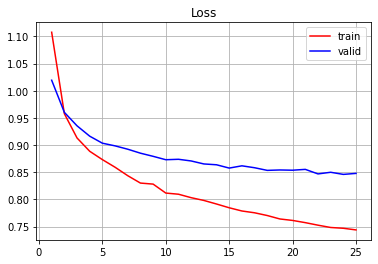


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 2...

**************************************************

Epoch: 1 | Train Loss: 1.11518 | Valid Loss: 0.99004 | Time: 35.49 seconds
Epoch: 2 | Train Loss: 0.96707 | Valid Loss: 0.92856 | Time: 35.50 seconds
Epoch: 3 | Train Loss: 0.92071 | Valid Loss: 0.90752 | Time: 35.51 seconds
Epoch: 4 | Train Loss: 0.89421 | Valid Loss: 0.88805 | Time: 35.45 seconds
Epoch: 5 | Train Loss: 0.87337 | Valid Loss: 0.88008 | Time: 35.66 seconds
Epoch: 6 | Train Loss: 0.85909 | Valid Loss: 0.86618 | Time: 35.42 seconds
Epoch: 7 | Train Loss: 0.84891 | Valid Loss: 0.86243 | Time: 35.44 seconds
Epoch: 8 | Train Loss: 0.83576 | Valid Loss: 0.85661 | Time: 35.39 seconds
Epoch: 9 | Train Loss: 0.82337 | Valid Loss: 0.85327 | Time: 35.54 seconds
Epoch: 10 | Train Loss: 0.819

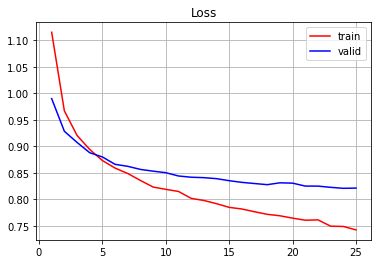


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 3...

**************************************************

Epoch: 1 | Train Loss: 1.10756 | Valid Loss: 1.08482 | Time: 35.34 seconds
Epoch: 2 | Train Loss: 0.96311 | Valid Loss: 1.02405 | Time: 35.51 seconds
Epoch: 3 | Train Loss: 0.91407 | Valid Loss: 1.00381 | Time: 35.60 seconds
Epoch: 4 | Train Loss: 0.89082 | Valid Loss: 0.98378 | Time: 35.82 seconds
Epoch: 5 | Train Loss: 0.86994 | Valid Loss: 0.97825 | Time: 35.65 seconds
Epoch: 6 | Train Loss: 0.85539 | Valid Loss: 0.97174 | Time: 35.52 seconds
Epoch: 7 | Train Loss: 0.84023 | Valid Loss: 0.96291 | Time: 35.68 seconds
Epoch: 8 | Train Loss: 0.83402 | Valid Loss: 0.96141 | Time: 35.46 seconds
Epoch: 9 | Train Loss: 0.82472 | Valid Loss: 0.95029 | Time: 35.53 seconds
Epoch: 10 | Train Loss: 0.819

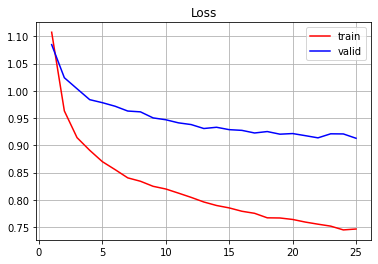


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 4...

**************************************************

Epoch: 1 | Train Loss: 1.11525 | Valid Loss: 0.92076 | Time: 35.65 seconds
Epoch: 2 | Train Loss: 0.96353 | Valid Loss: 0.87078 | Time: 35.43 seconds
Epoch: 3 | Train Loss: 0.92004 | Valid Loss: 0.84865 | Time: 35.42 seconds
Epoch: 4 | Train Loss: 0.88991 | Valid Loss: 0.83797 | Time: 35.53 seconds
Epoch: 5 | Train Loss: 0.87461 | Valid Loss: 0.82866 | Time: 35.47 seconds
Epoch: 6 | Train Loss: 0.85956 | Valid Loss: 0.82382 | Time: 35.33 seconds
Epoch: 7 | Train Loss: 0.84660 | Valid Loss: 0.81745 | Time: 35.39 seconds
Epoch: 8 | Train Loss: 0.83582 | Valid Loss: 0.81560 | Time: 35.61 seconds
Epoch: 9 | Train Loss: 0.82250 | Valid Loss: 0.80698 | Time: 35.89 seconds
Epoch: 10 | Train Loss: 0.818

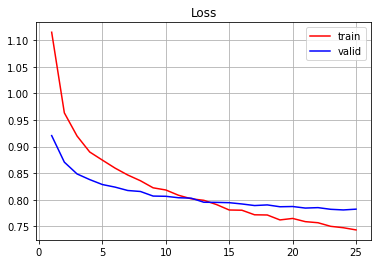


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 5...

**************************************************

Epoch: 1 | Train Loss: 1.10243 | Valid Loss: 1.07915 | Time: 35.42 seconds
Epoch: 2 | Train Loss: 0.95837 | Valid Loss: 1.03064 | Time: 35.43 seconds
Epoch: 3 | Train Loss: 0.91354 | Valid Loss: 1.00766 | Time: 35.33 seconds
Epoch: 4 | Train Loss: 0.88748 | Valid Loss: 0.99420 | Time: 35.49 seconds
Epoch: 5 | Train Loss: 0.86366 | Valid Loss: 0.98300 | Time: 35.39 seconds
Epoch: 6 | Train Loss: 0.85009 | Valid Loss: 0.97708 | Time: 35.54 seconds
Epoch: 7 | Train Loss: 0.84156 | Valid Loss: 0.96799 | Time: 35.44 seconds
Epoch: 8 | Train Loss: 0.82764 | Valid Loss: 0.96506 | Time: 35.38 seconds
Epoch: 9 | Train Loss: 0.81852 | Valid Loss: 0.96527 | Time: 35.40 seconds
Epoch: 10 | Train Loss: 0.808

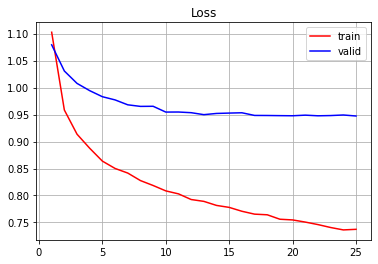


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 6...

**************************************************

Epoch: 1 | Train Loss: 1.10621 | Valid Loss: 1.01690 | Time: 35.61 seconds
Epoch: 2 | Train Loss: 0.95820 | Valid Loss: 0.96227 | Time: 35.82 seconds
Epoch: 3 | Train Loss: 0.91546 | Valid Loss: 0.93463 | Time: 36.29 seconds
Epoch: 4 | Train Loss: 0.89212 | Valid Loss: 0.91947 | Time: 35.79 seconds
Epoch: 5 | Train Loss: 0.87766 | Valid Loss: 0.90194 | Time: 35.95 seconds
Epoch: 6 | Train Loss: 0.85585 | Valid Loss: 0.89255 | Time: 35.82 seconds
Epoch: 7 | Train Loss: 0.84230 | Valid Loss: 0.88836 | Time: 35.80 seconds
Epoch: 8 | Train Loss: 0.83459 | Valid Loss: 0.88365 | Time: 35.86 seconds
Epoch: 9 | Train Loss: 0.81955 | Valid Loss: 0.87948 | Time: 35.92 seconds
Epoch: 10 | Train Loss: 0.814

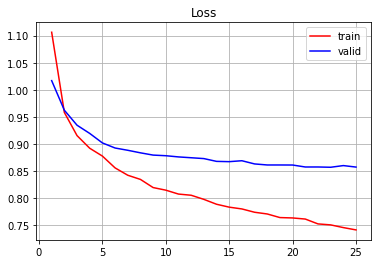


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 7...

**************************************************

Epoch: 1 | Train Loss: 1.10302 | Valid Loss: 1.05866 | Time: 35.93 seconds
Epoch: 2 | Train Loss: 0.95500 | Valid Loss: 1.01667 | Time: 36.05 seconds
Epoch: 3 | Train Loss: 0.91342 | Valid Loss: 0.99652 | Time: 36.42 seconds
Epoch: 4 | Train Loss: 0.88036 | Valid Loss: 0.98076 | Time: 36.25 seconds
Epoch: 5 | Train Loss: 0.86228 | Valid Loss: 0.97304 | Time: 36.06 seconds
Epoch: 6 | Train Loss: 0.84707 | Valid Loss: 0.96457 | Time: 35.96 seconds
Epoch: 7 | Train Loss: 0.84071 | Valid Loss: 0.95366 | Time: 36.18 seconds
Epoch: 8 | Train Loss: 0.82326 | Valid Loss: 0.95370 | Time: 36.19 seconds
Epoch: 9 | Train Loss: 0.81807 | Valid Loss: 0.94705 | Time: 35.99 seconds
Epoch: 10 | Train Loss: 0.806

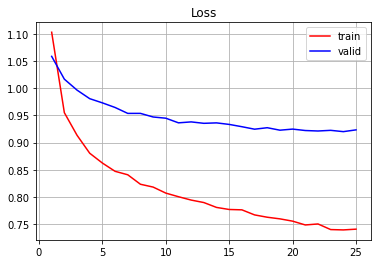


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 8...

**************************************************

Epoch: 1 | Train Loss: 1.10706 | Valid Loss: 0.88390 | Time: 35.63 seconds
Epoch: 2 | Train Loss: 0.96731 | Valid Loss: 0.82044 | Time: 35.67 seconds
Epoch: 3 | Train Loss: 0.92377 | Valid Loss: 0.79176 | Time: 35.65 seconds
Epoch: 4 | Train Loss: 0.89979 | Valid Loss: 0.77480 | Time: 35.77 seconds
Epoch: 5 | Train Loss: 0.87556 | Valid Loss: 0.76110 | Time: 35.66 seconds
Epoch: 6 | Train Loss: 0.86215 | Valid Loss: 0.75761 | Time: 35.52 seconds
Epoch: 7 | Train Loss: 0.84747 | Valid Loss: 0.75067 | Time: 35.76 seconds
Epoch: 8 | Train Loss: 0.83904 | Valid Loss: 0.74805 | Time: 35.63 seconds
Epoch: 9 | Train Loss: 0.82871 | Valid Loss: 0.74130 | Time: 35.69 seconds
Epoch: 10 | Train Loss: 0.822

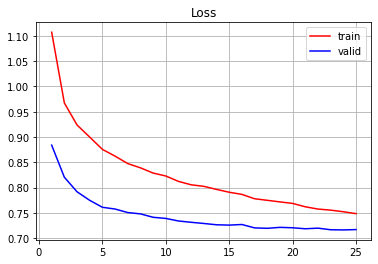


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 9...

**************************************************

Epoch: 1 | Train Loss: 1.10399 | Valid Loss: 1.02999 | Time: 36.06 seconds
Epoch: 2 | Train Loss: 0.96241 | Valid Loss: 0.96512 | Time: 36.06 seconds
Epoch: 3 | Train Loss: 0.91745 | Valid Loss: 0.92913 | Time: 35.97 seconds
Epoch: 4 | Train Loss: 0.89160 | Valid Loss: 0.91440 | Time: 36.05 seconds
Epoch: 5 | Train Loss: 0.87233 | Valid Loss: 0.89850 | Time: 36.04 seconds
Epoch: 6 | Train Loss: 0.85928 | Valid Loss: 0.88408 | Time: 35.78 seconds
Epoch: 7 | Train Loss: 0.84928 | Valid Loss: 0.87695 | Time: 35.99 seconds
Epoch: 8 | Train Loss: 0.83886 | Valid Loss: 0.87091 | Time: 35.91 seconds
Epoch: 9 | Train Loss: 0.82865 | Valid Loss: 0.85823 | Time: 35.96 seconds
Epoch: 10 | Train Loss: 0.817

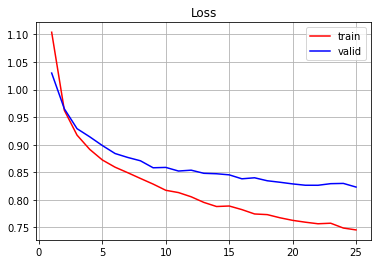


**************************************************

Building Train and Validation DataLoaders ...

**************************************************

Building Model ...

**************************************************

Training Fold 10...

**************************************************

Epoch: 1 | Train Loss: 1.11550 | Valid Loss: 0.96569 | Time: 35.75 seconds
Epoch: 2 | Train Loss: 0.96975 | Valid Loss: 0.90215 | Time: 35.37 seconds
Epoch: 3 | Train Loss: 0.91873 | Valid Loss: 0.87933 | Time: 35.50 seconds
Epoch: 4 | Train Loss: 0.89556 | Valid Loss: 0.85931 | Time: 35.38 seconds
Epoch: 5 | Train Loss: 0.87404 | Valid Loss: 0.84967 | Time: 35.31 seconds
Epoch: 6 | Train Loss: 0.86183 | Valid Loss: 0.84054 | Time: 35.45 seconds
Epoch: 7 | Train Loss: 0.84953 | Valid Loss: 0.83526 | Time: 35.42 seconds
Epoch: 8 | Train Loss: 0.83795 | Valid Loss: 0.83190 | Time: 35.39 seconds
Epoch: 9 | Train Loss: 0.82599 | Valid Loss: 0.82495 | Time: 35.46 seconds
Epoch: 10 | Train Loss: 0.82

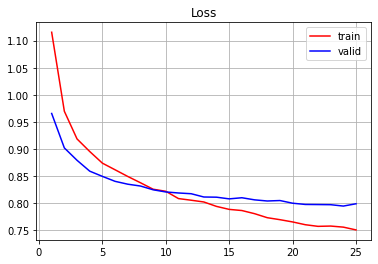


**************************************************

Total Time to 10 Fold CV : 149.20 minutes

**************************************************

Fold 1, RMSE: 19.08473
Fold 2, RMSE: 18.69847
Fold 3, RMSE: 19.52741
Fold 4, RMSE: 18.30344
Fold 5, RMSE: 20.03863
Fold 6, RMSE: 19.17230
Fold 7, RMSE: 19.73141
Fold 8, RMSE: 17.52850
Fold 9, RMSE: 18.71924
Fold 10, RMSE: 18.28986

**************************************************

Best RMSE : 17.52850
Avg RMSE  : 18.90940

**************************************************



In [10]:
main()

## End

In [11]:
breaker()
print("Notebook Rumtime : {:.2f} minutes".format((time() - notebook_start_time)/60))
breaker()


**************************************************

Notebook Rumtime : 149.44 minutes

**************************************************

